In [12]:
!pwd

/content/drive/MyDrive/programming projects/Depth-Anything


In [13]:
%cd '/content/drive/MyDrive/programming projects/Depth-Anything'

/content/drive/MyDrive/programming projects/Depth-Anything


In [43]:
import os

import cv2
import torch
import requests
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
from torchvision.transforms import Compose

from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

def get_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return np.array(img)

def get_image_from_files(dir):
  images_list = list()
  for root, dirs, files in os.walk(dir):
    for file in files:
      images_list.append(dir+file)
  print(f'There are {len(images_list)} images in our dataset')
  return images_list

dir = "/content/drive/MyDrive/programming projects/Depth-Anything/dataset_add/"
images_list = get_image_from_files(dir)

There are 9 images in our dataset


# Obtain depth

In [71]:
# img_url = "https://koitu.com/gallery/photos/PXL_20240118_062519789.jpg"
# img_url = "https://www.prints-online.com/p/164/exposition-universelle-internationale-paris-23439848.jpg"
# img = get_image_from_url(img_url)

raw_image = cv2.imread(images_list[1])
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) / 255.0

In [72]:
encoder = 'vitl' # can also be 'vits', 'vitb' or 'vitl'

transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])

depth_anything = DepthAnything.from_pretrained('LiheYoung/depth_anything_{:}14'.format(encoder)).eval()

In [73]:
%%time
image_resized = transform({'image': raw_image})['image']
image_resized = torch.from_numpy(image_resized).unsqueeze(0)

depth = depth_anything(image_resized)  # depth shape: 1xHxW
depth = depth.detach().squeeze()

CPU times: user 50.7 s, sys: 13.1 s, total: 1min 3s
Wall time: 17.2 s


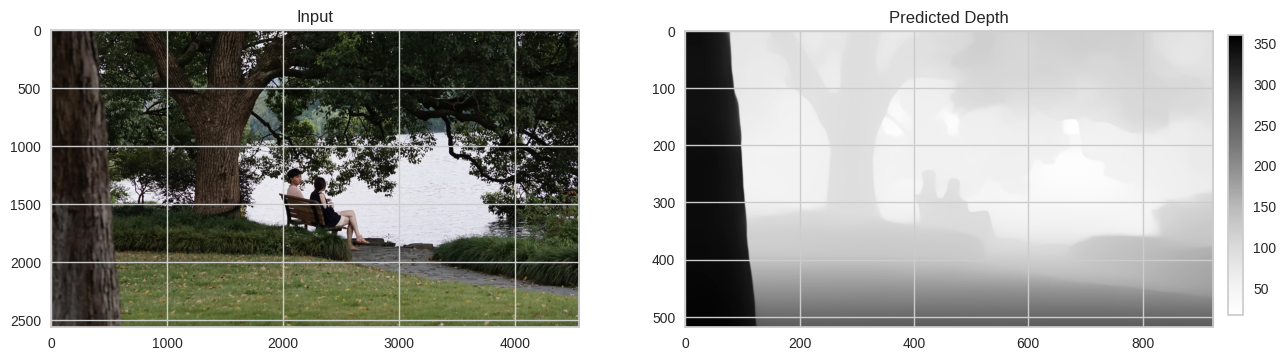

In [74]:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.title('Input')
plt.imshow(raw_image)

plt.subplot(122)
plt.title('Predicted Depth')
plt.imshow(depth)

plt.colorbar(cax = plt.axes([0.91, 0.3, 0.01, 0.4]))

# Clustering

In [75]:
d = depth.numpy()
n, m = np.shape(d)

d = np.reshape(d, (n*m, 1))

## Find the optimal number of clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

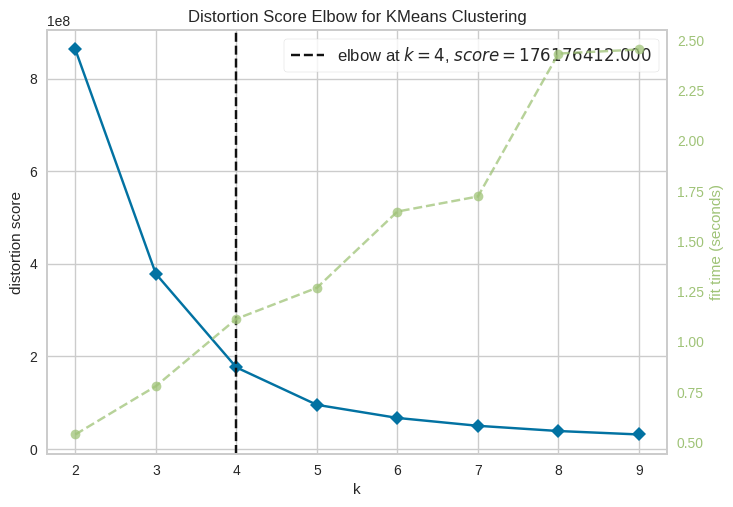

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [76]:
# initialize KMeans model
model = KMeans(random_state=42)

# Initialize KElbowVisualizer, set k in the range 2 to 10
visualizer = KElbowVisualizer(model, k=(2,10))

# Fitting data and plotting elbows
visualizer.fit(d)
visualizer.show()

## Kmeans

In [77]:
n_clusters = visualizer.elbow_value_

k_means = KMeans(n_clusters=n_clusters, random_state=42)
k_means.fit(d)
res = k_means.predict(d)
res = np.reshape(res, (n,m))

# Used to store the cluster center value corresponding to each data point
res_clusters = k_means.labels_
res_labels = np.reshape(res_clusters, (n,m)).astype(np.float64)
res_centers = k_means.cluster_centers_[k_means.labels_]
res_depth = np.reshape(res_centers, (n,m))

# Upsample the segmented depth image
original_height, original_width = raw_image.shape[:2]
res_depth_upsampled = cv2.resize(res_depth, (original_width, original_height), interpolation=cv2.INTER_CUBIC)
res_labels_upsampled = cv2.resize(res_labels, (original_width, original_height), interpolation=cv2.INTER_CUBIC)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


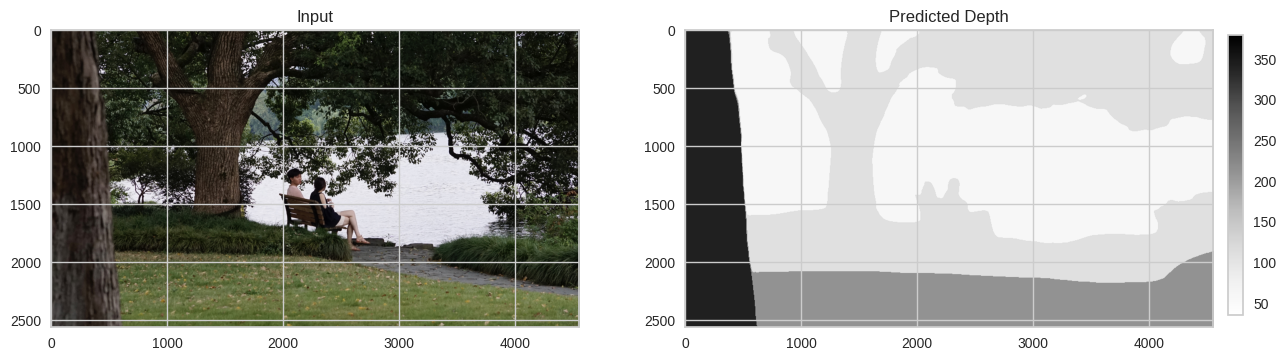

In [78]:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.title('Input')
plt.imshow(raw_image)

plt.subplot(122)
plt.title('Predicted Depth')
plt.imshow(res_depth_upsampled)

plt.colorbar(cax = plt.axes([0.91, 0.3, 0.01, 0.4]))

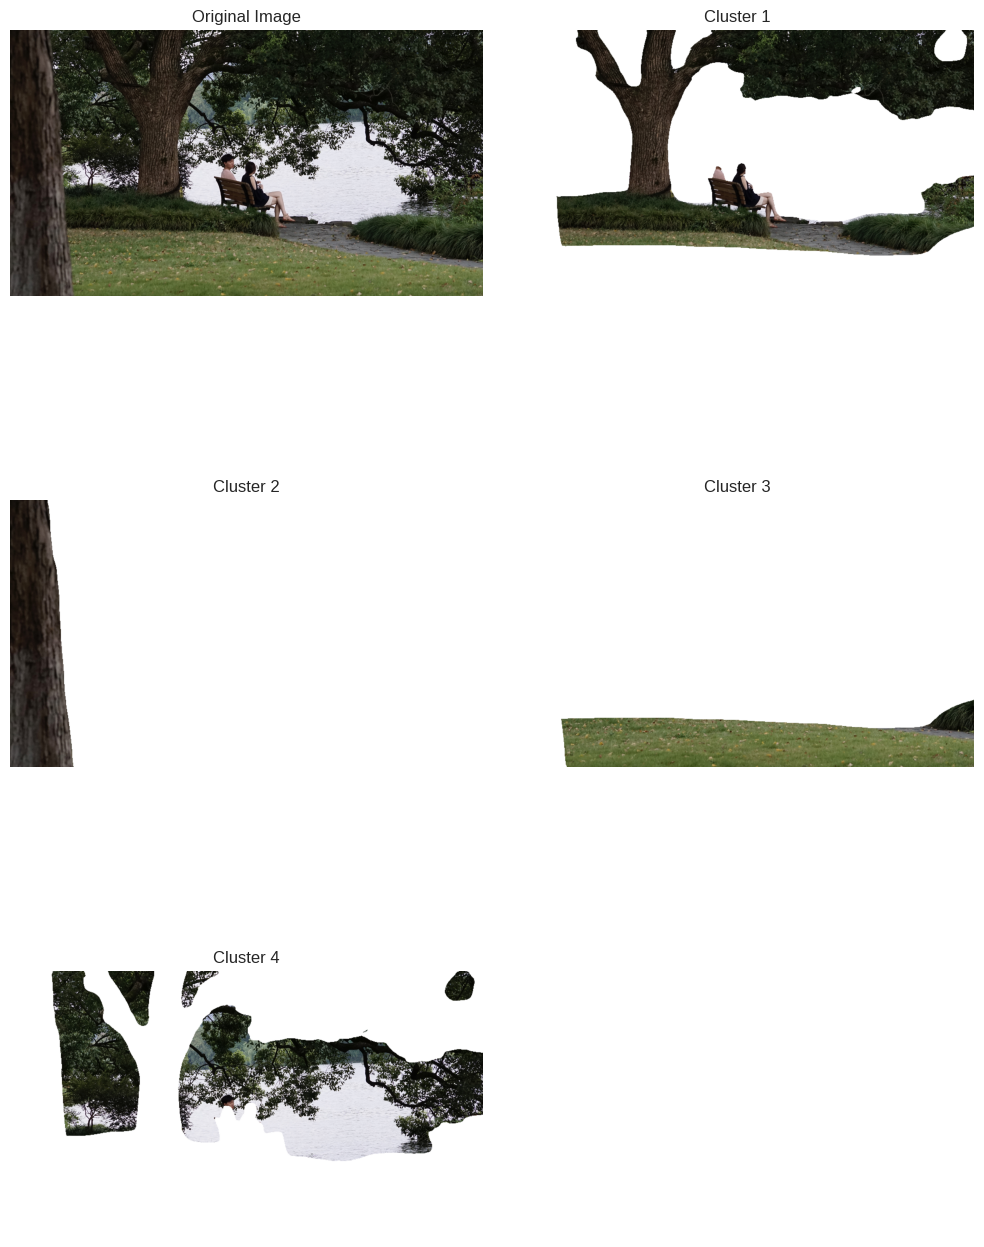

In [79]:
plt.figure(figsize=(10,15))
rows = (n_clusters + 1 + 1) // 2


# Display the original img
plt.subplot(rows, 2, 1)
plt.title('Original Image')
plt.imshow(raw_image)
plt.axis('off')

for i in range(n_clusters):
    # Create a background the same size as the original image but with all pixels white
    cluster_img = np.ones_like(raw_image)

    # Find the pixel points that belong to the current cluster
    # and set the color of these points to the color in the original image
    mask = res_labels_upsampled == i
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    cluster_img[mask] = raw_image[mask]

    plt.subplot(rows, 2, i + 2)
    plt.title(f'Cluster {i + 1}')
    plt.imshow(cluster_img)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [80]:
# Get the cluster labels for each pixel and the centroids of each cluster (i.e., average depths)
labels = k_means.labels_
centroids = k_means.cluster_centers_

# Calculate the depth difference (distortion) between each pixel and the centroid of its cluster
distortions = np.abs(d - res_centers)

# Reshape the distortions back to the original image size for visualization
distortions_image = np.reshape(distortions, (n, m))

# Optionally: Calculate the average distortion for each cluster
for i in range(n_clusters):
    cluster_distortion = np.mean(distortions[labels == i])
    print(f"Cluster {i} average distortion: {cluster_distortion}")
print("The average distortion over the complete image:", np.mean(distortions))

Cluster 0 average distortion: 15.891810417175293
Cluster 1 average distortion: 7.3740434646606445
Cluster 2 average distortion: 26.77398681640625
Cluster 3 average distortion: 10.040753364562988
The average distortion over the complete image: 14.5920105
